# Signature Classification

![img](../images/signature_banner.jpeg)

## Overview

The aim of this analysis is to identify fraudulent signatures in a dataset. My audience here is _______. Using just a small dataset with only 300 sample I was able to create a 

## Business Problem

Currently institutions and businesses recognize signatures as the primary way of authenticating transactions. Signatures are used to sign checks, authorize documents and contracts, and validate credit card transactions. According to recent studies, check fraud costs banks about $900M a year with 22 percent of all fraudulent checks attributed to signature fraud. Therefor, creating an algorithm to identify signature fraud is a valuable asset. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
import zipfile
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' #This prevents kernel shut down due to xgboost conflict
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, metrics, regularizers, losses
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import auc, recall_score, precision_score, \
                            confusion_matrix, plot_confusion_matrix, \
                            roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV 
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.model_selection import GridSearchCV 
import pickle

np.random.seed(42)

/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zachrauch/opt/anaconda3/envs/tf-test/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zachrauch/op

## Colab Necessary Code

Google Colab was used to help streamline the modeling process. Modeling using Convolutional Neural Networks can be computationally expensive, so if you would like to run this notebook faster, I would recommend creating a Colab account and storing the data, discussed below, in a Google Drive file. 

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

In [5]:
# pip install unzip
# import unzip
# !unzip /content/drive/MyDrive/signatures.zip 

## Data

The data used in this notebook can be found [here](https://www.kaggle.com/datasets/divyanshrai/handwritten-signatures). The dataset contains just 300 samples of genuine and forged signatures from 30 people, of which 50 percent are genuine and 50 percent are forged. 

In [2]:
# instantiate ImageDataGenerator scaling each pixel's values down to a scale of 1
img = ImageDataGenerator(rescale=1/255)

In [3]:
data_path = '../Data/sample_Signature/sample_Signature/'
# For Colab 
# data_path = '/content/sample_Signature/sample_Signature/'

In [4]:
# Importing the data
data = img.flow_from_directory(data_path, color_mode='grayscale',\
                               batch_size=300, class_mode='binary')

Found 300 images belonging to 2 classes.


In [5]:
data.class_indices

{'forged': 0, 'genuine': 1}

In [6]:
data_images, data_labels = next(data)

In [7]:
data_images.shape

(300, 256, 256, 1)

In [8]:
data_labels.shape

(300,)

In [9]:
X_train, X_test, y_train, y_test = train_test_split( \
            data_images, data_labels, random_state=42, test_size=.2)

In [10]:
X_train.shape

(240, 256, 256, 1)

In [11]:
y_train.shape

(240,)

Above we instantiate Keras' ImageDataGenerator which will scale each pixel's values down to a value of 1. Next we import the data and separate into the images themselves and their respective labels. The class indices indicate what the label values correspond to. Finally we split it into a train and test dataset.

### Image Augmentation

Because we have such a small dataset it is important to use image augmentation to artificially expand the training dataset. Below we do several forms of data augmentation individually before combining the techniques at the end.

#### Zoom Augmentation

The first technique we explore is zoom range. Entering a range of values, .25 and 1 in this case, randomly applies a zoom to each image within that range.

In [12]:
aug = ImageDataGenerator(zoom_range=[.25,1])
aug.fit(X_train)
aug_data = aug.flow(X_train, y_train, batch_size=240)

In [17]:
aug_images, aug_labels = next(aug_data)

In [18]:
aug_images.shape

(240, 256, 256, 1)

In [19]:
aug_labels.shape

(240,)

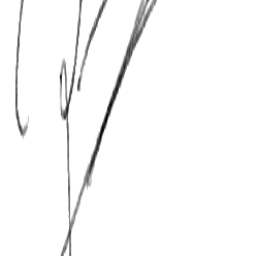

In [20]:
array_to_img(aug_images[0])

In [21]:
new_images1 = np.concatenate([X_train, aug_images])
new_labels1 = np.concatenate([y_train, aug_labels])

In [22]:
new_images1.shape

(480, 256, 256, 1)

In [23]:
new_labels1.shape

(480,)

#### Width Augmentation

The next method for augmentation used was width shift range. With a range of .3 the images will be randomly assigned a width down to .3 of the original image size. 

In [24]:
aug = ImageDataGenerator(width_shift_range=.3)
aug.fit(X_train)
aug2_data = aug.flow(X_train, y_train, batch_size=240)

In [25]:
aug2_images, aug2_labels = next(aug2_data)

In [26]:
new_images2 = np.concatenate([new_images1, aug2_images])
new_labels2 = np.concatenate([new_labels1, aug2_labels])

#### Height Augmentation

The next method for augmentation used was height shift range. With a range of .3 the images will be randomly assigned a height down to .3 of the original image size.

In [27]:
aug = ImageDataGenerator(height_shift_range=.3)
aug.fit(X_train)
aug3_data = aug.flow(X_train, y_train, batch_size=240)

In [28]:
aug3_images, aug3_labels = next(aug3_data)

In [29]:
new_images3 = np.concatenate([new_images2, aug3_images])
new_labels3 = np.concatenate([new_labels2, aug3_labels])

#### Rotation Augmentation

Next we apply a random rotation to each image up to 30 degrees.

In [30]:
aug = ImageDataGenerator(rotation_range=30)
aug.fit(X_train)
aug4_data = aug.flow(X_train, y_train, batch_size=240)

In [31]:
aug4_images, aug4_labels = next(aug4_data)

In [32]:
new_images4 = np.concatenate([new_images3, aug4_images])
new_labels4 = np.concatenate([new_labels3, aug4_labels])

#### Shear Augmentation

We then apply a random shear value to each image. This angles the corners of each image up to 30 degrees.

In [33]:
aug = ImageDataGenerator(shear_range=30)
aug.fit(X_train)
aug5_data = aug.flow(X_train, y_train, batch_size=240)

In [34]:
aug5_images, aug5_labels = next(aug5_data)

In [35]:
new_images5 = np.concatenate([new_images4, aug5_images])
new_labels5 = np.concatenate([new_labels4, aug5_labels])

#### Brightness Augmentation

Finally we have brightness augmentation. This applies a random brightness shift within the provided range. 

In [36]:
aug = ImageDataGenerator(brightness_range=(1,2))
aug.fit(X_train)
aug5_data = aug.flow(X_train, y_train, batch_size=240)

In [37]:
aug6_images, aug6_labels = next(aug5_data)

In [38]:
new_images6 = np.concatenate([new_images5, aug6_images])
new_labels6 = np.concatenate([new_labels5, aug6_labels])

In [39]:
new_labels6.shape

(1680,)

#### A little bit of everything Augmentation

Now that we have augmented each image with a single augmentation, we will again augment all images with a combination of each augmentation. 

In [40]:
aug = ImageDataGenerator(zoom_range=[.7,.9], width_shift_range=.15, height_shift_range=.15, rotation_range=15, shear_range=15, brightness_range=(1,1.5))
aug.fit(new_images6)
aug_data_final = aug.flow(new_images6, new_labels6, batch_size=1680)

In [41]:
aug_final_images, aug_final_labels = next(aug_data_final)

In [42]:
final_images = np.concatenate([new_images6, aug_final_images])
final_labels = np.concatenate([new_labels6, aug_final_labels])

In [43]:
final_images.shape

(3360, 256, 256, 1)

In [44]:
final_labels.shape

(3360,)

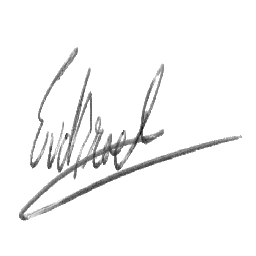

In [45]:
array_to_img(final_images[0])

In [46]:
final_labels[0]

1.0

The above example image would be considered a genuine signature.

## Modeling

### Dummy Model

Our first model will be a baseline model for comparison. We will utilize Sklearn's DummyClassifier which uses the most frequent class as it's prediction. 

In [47]:
dummy_model = DummyClassifier(strategy='most_frequent')
dummy_model.fit(final_images, final_labels)

DummyClassifier(strategy='most_frequent')

In [46]:
dummy_preds = dummy_model.predict(X_test)

dummy_acc = dummy_model.score(X_test, y_test)

In [47]:
dummy_acc

0.43333333333333335

### Model 1

In [48]:
adam = Adam(learning_rate=.0001)

In [49]:
def build_model():
    model1 = Sequential()
    model1.add(layers.Conv2D(filters=64,
                       kernel_size=(3,3),
                       activation='relu',
                       input_shape=(256,256,1)))

    model1.add(layers.MaxPool2D())

    model1.add(layers.Conv2D(128, (3,3), activation='relu'))

    model1.add(layers.MaxPool2D())
    
    model1.add(layers.Flatten())
    model1.add(layers.Dense(64, activation='relu'))
    model1.add(layers.Dropout(.25))

    model1.add(layers.Dense(32, activation='relu', kernel_regularizer=l2(0.05)))

    model1.add(layers.Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
    model1.add(layers.Dropout(.25))
    
    model1.add(layers.Dense(1, activation='sigmoid'))

    model1.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model1 = scikit_learn.KerasClassifier(build_model,
                                          epochs=20, 
                                          batch_size=32, 
                                          verbose=2)

In [116]:
# Cross validation will be run in and pickled from colab to save time.
#model1_cv_results = cross_val_score(model1, final_images, final_labels).mean()

Train on 1612 samples
Epoch 1/10


KeyboardInterrupt: 

In [ ]:
#model1_cv_results

In [ ]:
# model1_cv_pickle = '../Data/model1_cv_pickle.sav'
# pickle.dump(model1_cv_results, open(model1_cv_pickle, 'wb'))

In [15]:
# Colab is running a newer version of tensorflow which is incompatible
# with my local machine. Therefor keras.save() and pickling won't work 
# from Colab and the model will be ran and saved here.
#ONLY run best model based on cv results
model1 = model1.fit(final_images, final_labels)

NameError: name 'model1' is not defined

In [ ]:
model1_pickle = '../Data/model1_pickle.sav'
pickle.dump(model1, open(model1_pickle, 'wb'))

In [ ]:
model1.save('../Data/model1.h5', save_format='h5')

In [ ]:
model1.save('../Data/model1.sav')